In [ ]:
import kagglehub
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
from sklearn.model_selection import GridSearchCV, train_test_split, KFold

### 1. EDA

In [ ]:
# 1. 최신 버전 데이터셋 다운로드
path = kagglehub.dataset_download("yasserh/housing-prices-dataset")

print(f"데이터가 다운로드된 경로: {path}")

# 2. 경로 내 파일 확인 (어떤 파일이 있는지 확인)
files = os.listdir(path)
print(f"폴더 내 파일 목록: {files}")

# 3. CSV 파일 로드

csv_filename = 'Housing.csv'
full_path = os.path.join(path, csv_filename)

df = pd.read_csv(full_path)

100%|██████████| 4.63k/4.63k [00:00<00:00, 7.07MB/s]

Extracting files...
데이터가 다운로드된 경로: /root/.cache/kagglehub/datasets/yasserh/housing-prices-dataset/versions/1
폴더 내 파일 목록: ['Housing.csv']


In [ ]:
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [ ]:
df.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


In [ ]:
df.describe(include='object')

,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea,furnishingstatus
count,545,545,545,545,545,545,545
unique,2,2,2,2,2,2,3
top,yes,no,no,no,no,no,semi-furnished
freq,468,448,354,520,373,417,227


In [ ]:
col1 = ['price','area','bedrooms','bathrooms','stories','parking']
col2 = ['mainroad', 'guestroom', 'basement', 'hotwaterheating',	'airconditioning', 'prefarea', 'furnishingstatus']

In [ ]:
### 1. 수치형 변수

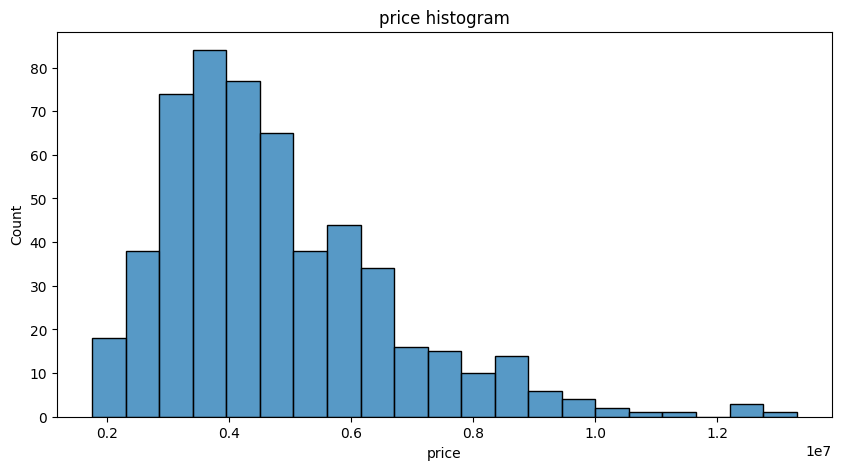

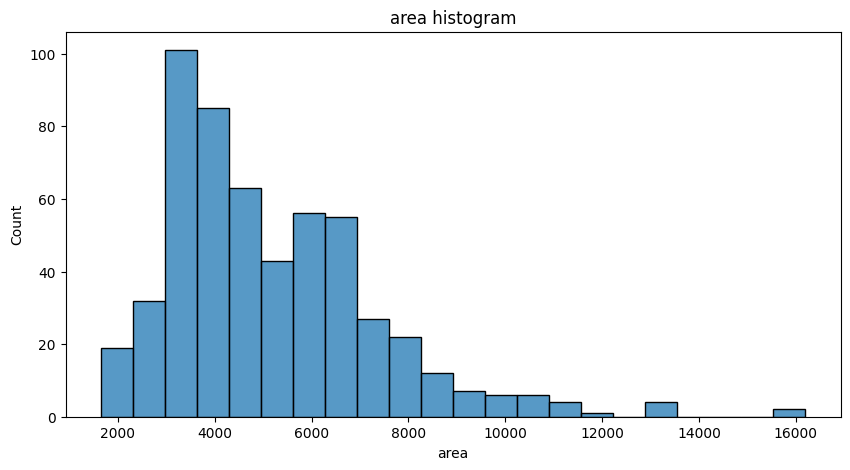

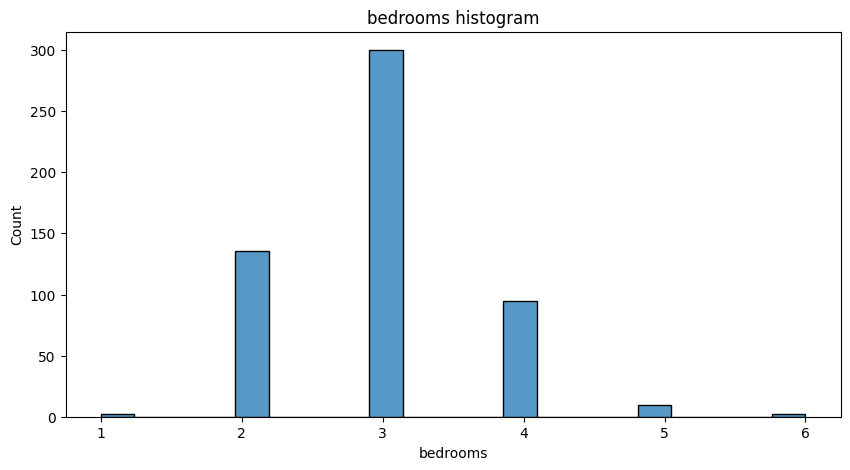

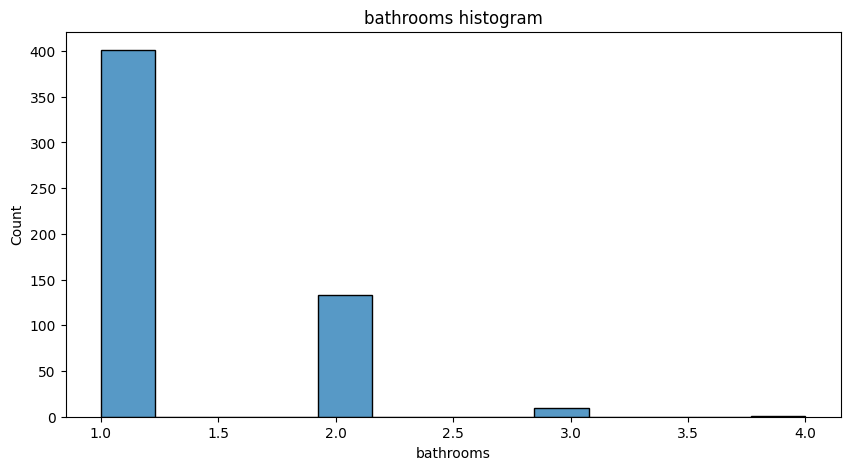

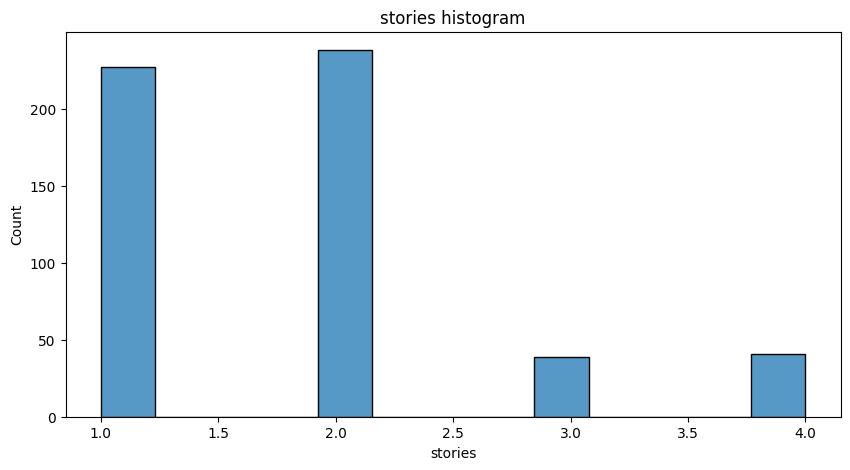

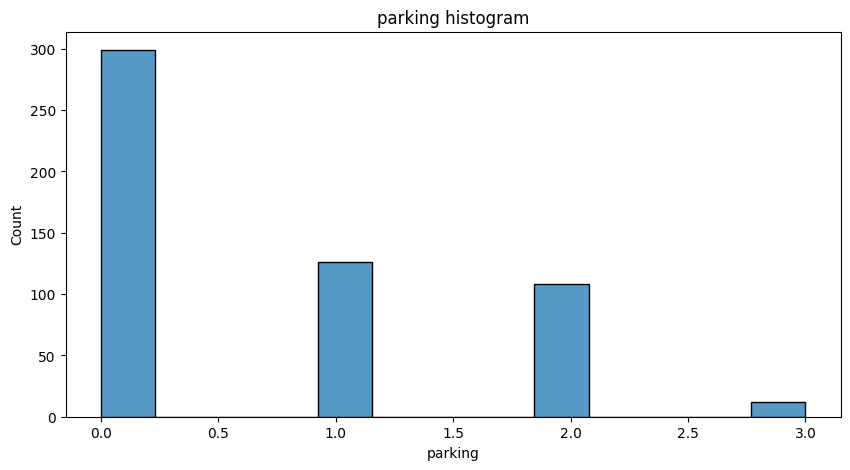

In [ ]:
for col in col1:
    plt.figure(figsize=(10,5))
    sns.histplot(data=df, x=col)
    plt.title(f'{col} histogram')
    plt.show

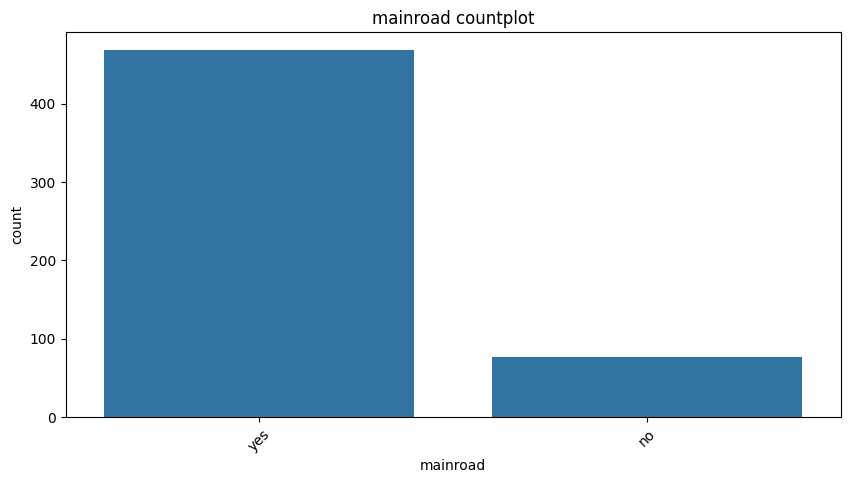

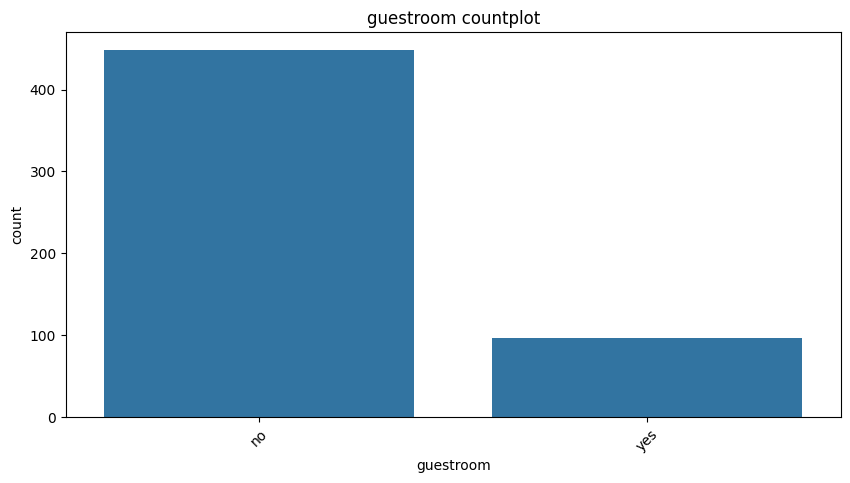

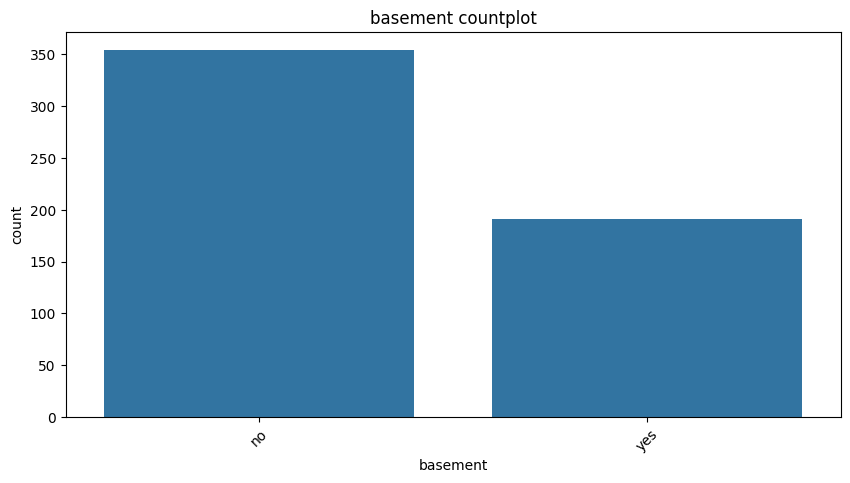

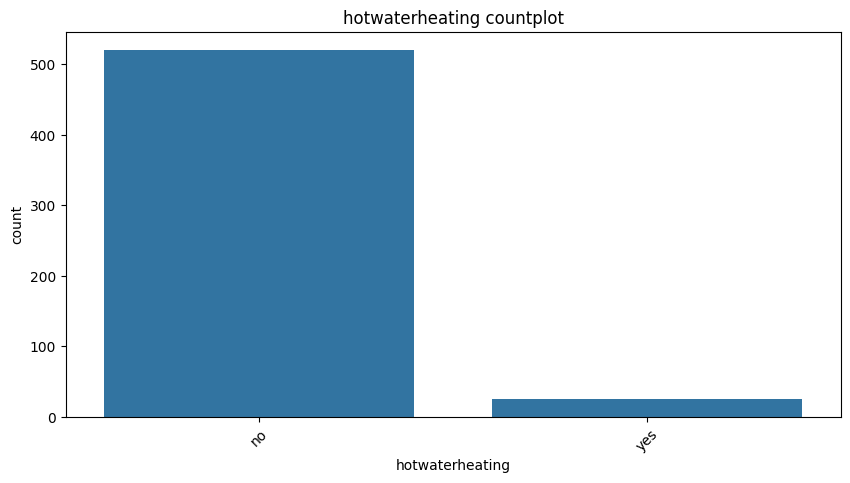

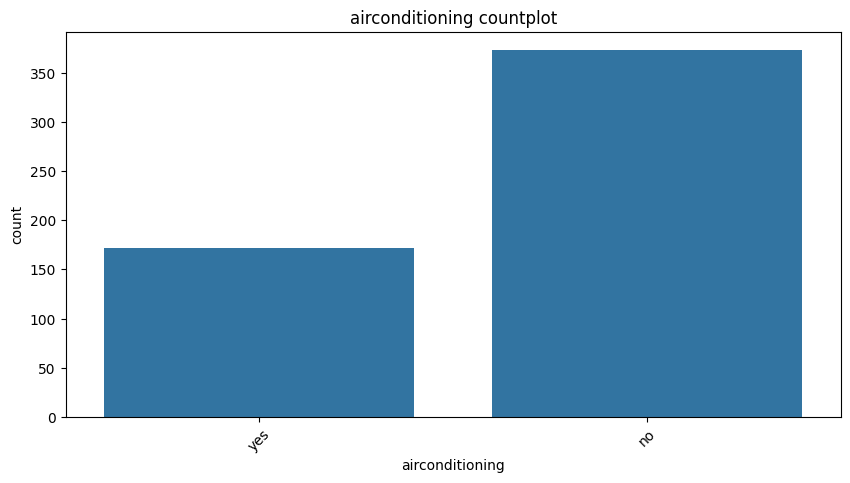

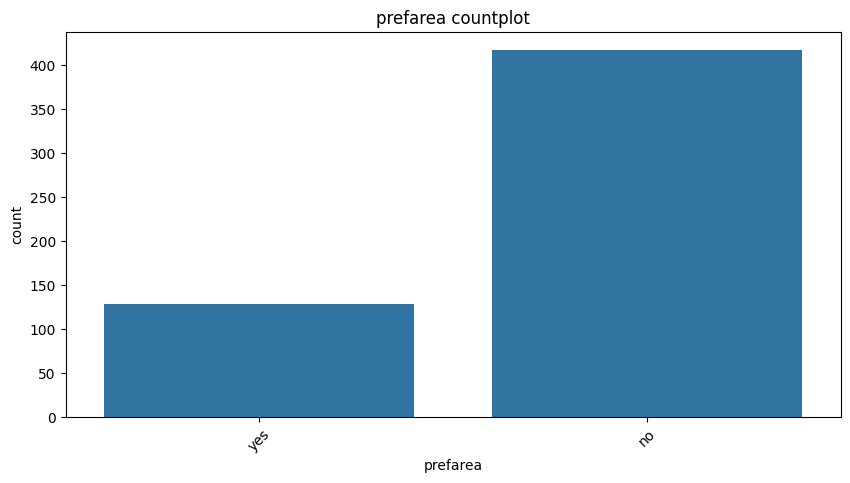

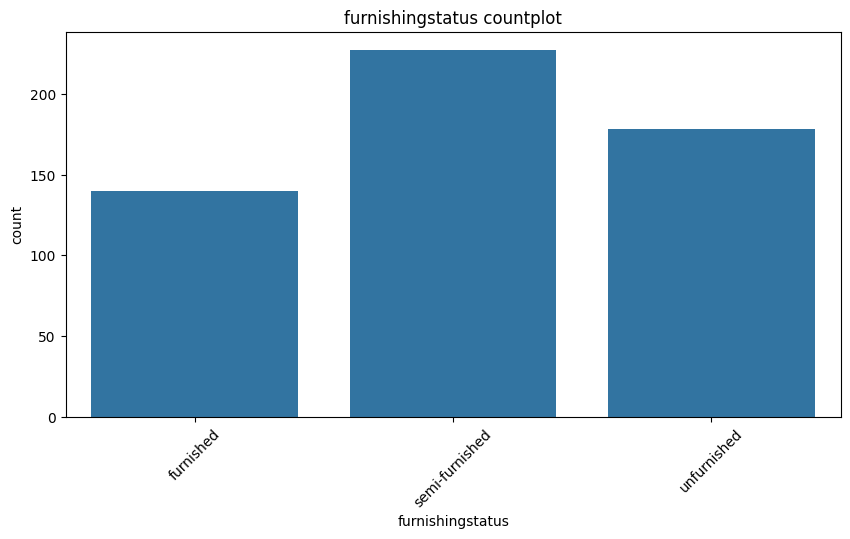

In [ ]:
### 2. 범주형 변수

for col in col2:
    plt.figure(figsize=(10,5))
    sns.countplot(data=df, x=col)
    plt.title(f'{col} countplot')
    plt.xticks(rotation=45)
    plt.show()

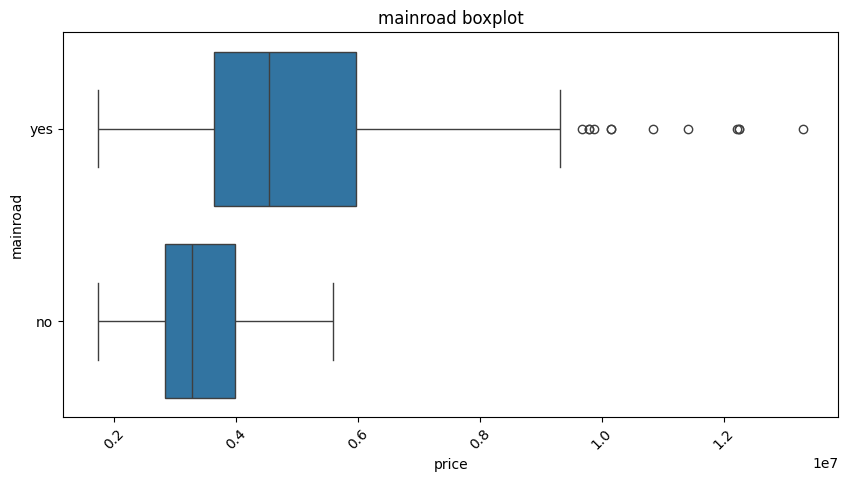

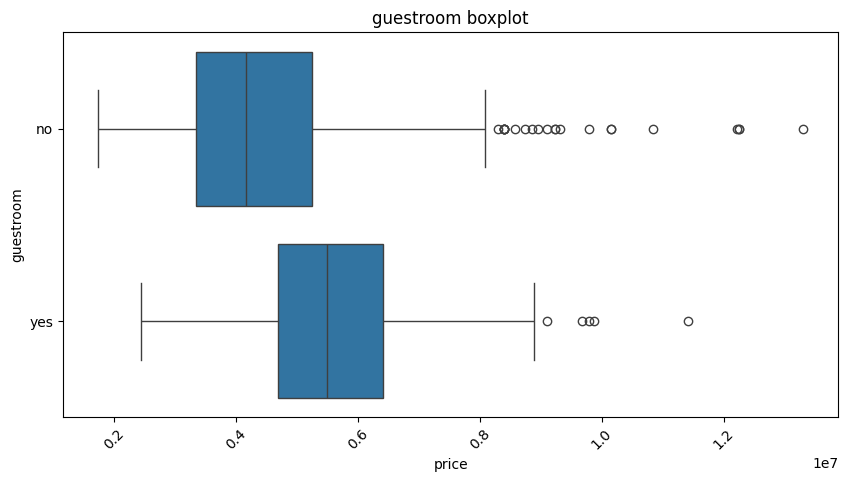

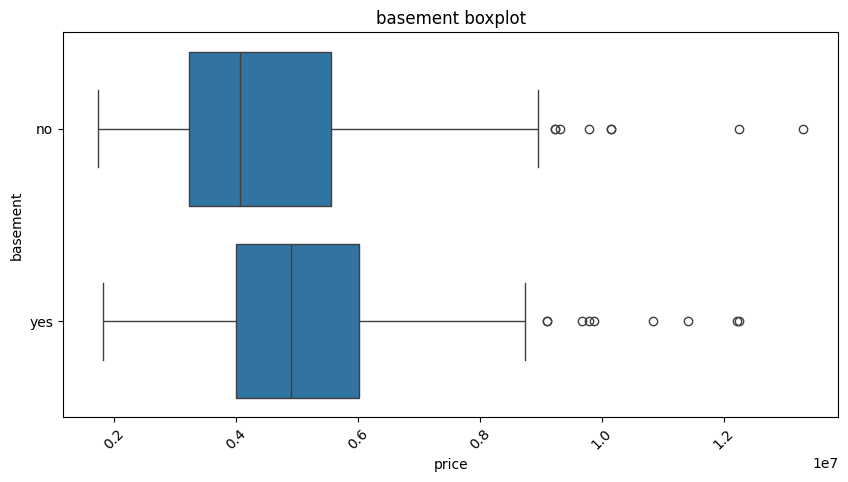

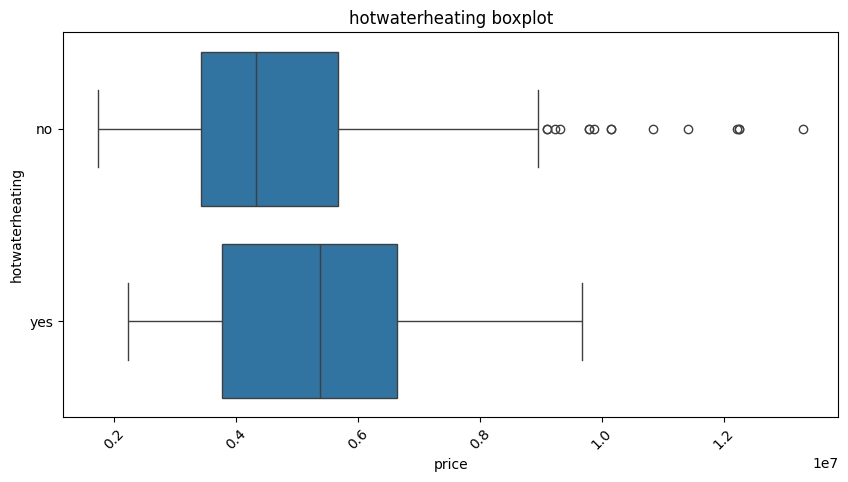

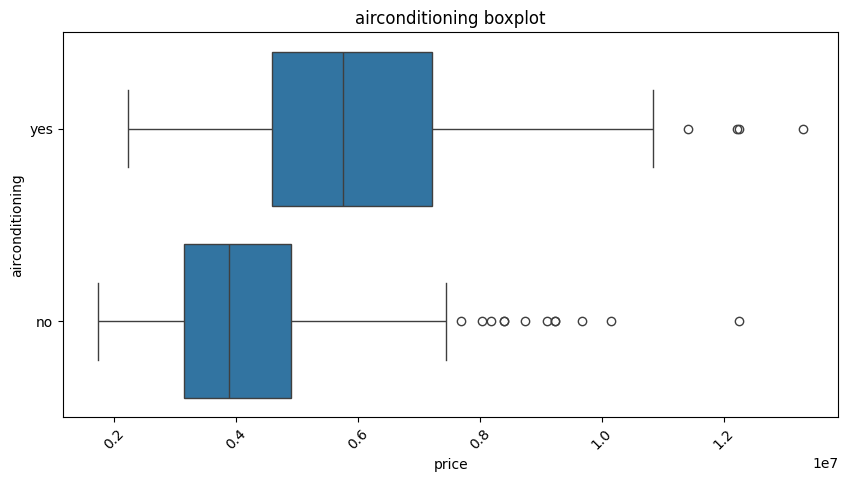

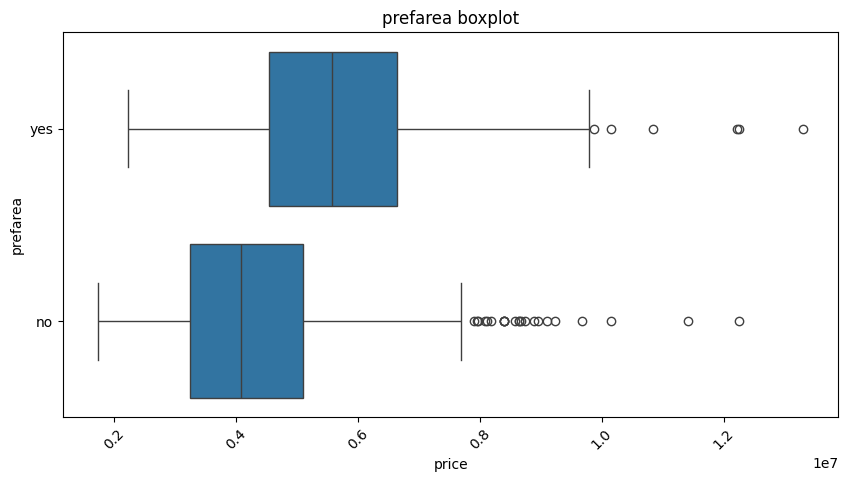

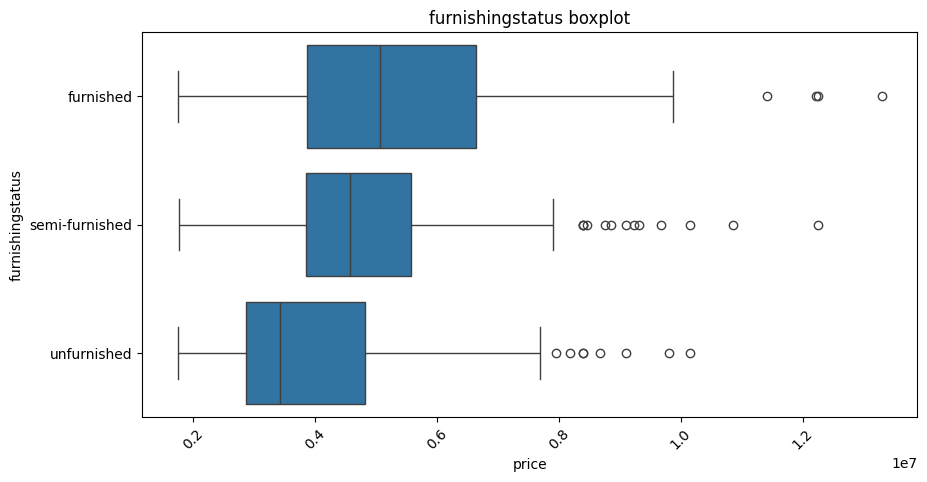

In [ ]:
for col in col2:
    plt.figure(figsize=(10,5))
    sns.boxplot(data=df,y=col,x='price')
    plt.title(f'{col} boxplot')
    plt.xticks(rotation=45)
    plt.show()

### 2. 데이터 전처리

In [ ]:

# 2. 스케일링
df_num = df[col1]
df_num['area_log'] = np.log1p(df_num['area'])
df_num.drop(columns='area',inplace=True)
df_num.drop(columns='price',inplace=True)

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_num)
df_scaled = pd.DataFrame(scaled,columns=df_num.columns)

# 3. 인코딩
df_cat = df[col2]

def function1(x):
    if x=='yes':
        return 1
    else:
        return 0

def function2(x):
    if x=='furnished':
        return 0
    elif x=='semi-furnished':
        return 1
    else:
        return 2

df_cat['furnishingstatus_encoded'] = df_cat['furnishingstatus'].apply(function2)
df_cat.drop(columns='furnishingstatus',inplace=True)

df_cat['main_road_encoded'] = df_cat['mainroad'].apply(function1)
df_cat.drop(columns='mainroad',inplace=True)

df_cat['guestroom_encoded'] = df_cat['guestroom'].apply(function1)
df_cat.drop(columns='guestroom',inplace=True)

df_cat['basement_encoded'] = df_cat['basement'].apply(function1)
df_cat.drop(columns='basement',inplace=True)

df_cat['hotwaterheating_encoded'] = df_cat['hotwaterheating'].apply(function1)
df_cat.drop(columns='hotwaterheating',inplace=True)

df_cat['airconditioning'] = df_cat['airconditioning'].apply(function1)
df_cat.drop(columns='airconditioning',inplace=True)

df_cat['prefarea'] = df_cat['prefarea'].apply(function1)
df_cat.drop(columns='prefarea',inplace=True)


/tmp/ipython-input-1061723895.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num['area_log'] = np.log1p(df_num['area'])
/tmp/ipython-input-1061723895.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num.drop(columns='area',inplace=True)
/tmp/ipython-input-1061723895.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num.drop(columns='price',inplace=True)
/tmp/ip

### 3. 데이터 모델링(baseline)

In [ ]:
X = pd.concat([df_scaled,df_cat],axis=1)
y = df['price']

X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2,random_state=42)


xgb = XGBRegressor(random_state=42,n_jobs=-1)
xgb.fit(X_train,y_train)

'''
# 3. 모델 학습 (과적합 방지 파라미터 추가 추천)
xgb = XGBRegressor(
    n_estimators=1000,   # 넉넉하게 설정
    learning_rate=0.05,  # 천천히 학습
    early_stopping_rounds=50, # 조기 종료 설정
    n_jobs=-1
)

# 조기 종료를 위해 eval_set 지정
xgb.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)
'''

y_pred = xgb.predict(X_val)

mse = mean_squared_error(y_val,y_pred)
mae = mean_absolute_error(y_val,y_pred)
r2 = r2_score(y_val,y_pred)

print(np.sqrt(mse),mae,r2)

1498610.268471426 1109072.875 0.5556827783584595


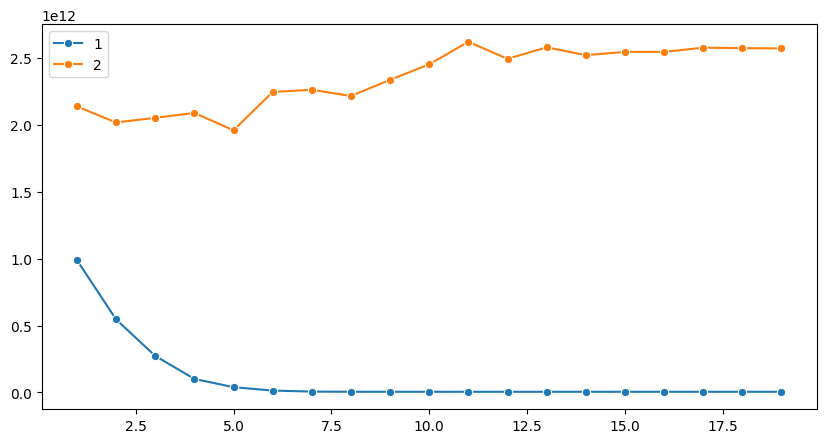

In [ ]:
nums = [i for i in range(1,20,1)]
arr1 = []
arr2 = []
for i in nums:

    xgb = XGBRegressor(max_depth=i,random_state=42,n_jobs=-1)
    xgb.fit(X_train,y_train)

    y_pred1 = xgb.predict(X_train)
    mse1 = mean_squared_error(y_train,y_pred1)
    arr1.append(mse1)

    y_pred2 = xgb.predict(X_val)
    mse2 = mean_squared_error(y_val,y_pred2)
    arr2.append(mse2)


plt.figure(figsize=(10,5))
sns.lineplot(x=nums,y=arr1,label='1',marker='o')
sns.lineplot(x=nums,y=arr2,label='2',marker='o')
plt.legend()
plt.show()




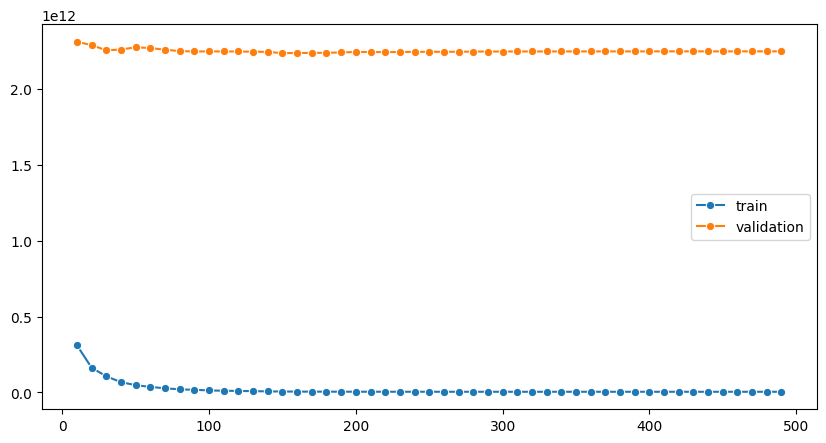

In [ ]:
nums = [i for i in range(10,500,10)]
arr1 = []
arr2 = []
for i in nums:

    xgb = XGBRegressor(n_estimators=i,random_state=42,n_jobs=-1)
    xgb.fit(X_train,y_train)

    y_pred1 = xgb.predict(X_train)
    mse1 = mean_squared_error(y_train,y_pred1)
    arr1.append(mse1)

    y_pred2 = xgb.predict(X_val)
    mse2 = mean_squared_error(y_val,y_pred2)
    arr2.append(mse2)


plt.figure(figsize=(10,5))
sns.lineplot(x=nums,y=arr1,label='train',marker='o')
sns.lineplot(x=nums,y=arr2,label='validation',marker='o')
plt.legend()
plt.show()




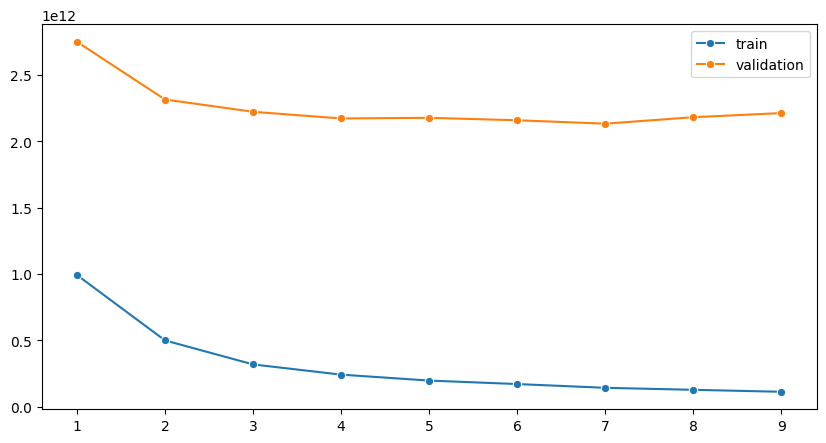

In [ ]:
nums = [i for i in range(1,10,1)]
arr1 = []
arr2 = []
for i in nums:

    xgb = XGBRegressor(learning_rate=i/100,random_state=42,n_jobs=-1)
    xgb.fit(X_train,y_train)

    y_pred1 = xgb.predict(X_train)
    mse1 = mean_squared_error(y_train,y_pred1)
    arr1.append(mse1)

    y_pred2 = xgb.predict(X_val)
    mse2 = mean_squared_error(y_val,y_pred2)
    arr2.append(mse2)


plt.figure(figsize=(10,5))
sns.lineplot(x=nums,y=arr1,label='train',marker='o')
sns.lineplot(x=nums,y=arr2,label='validation',marker='o')
plt.legend()
plt.show()




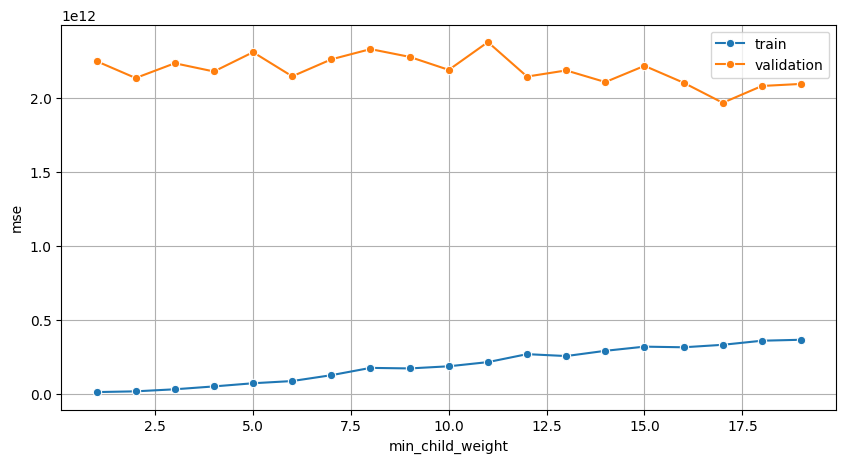

In [ ]:
nums = [i for i in range(1,20,1)]
arr1 = []
arr2 = []
for i in nums:

    xgb = XGBRegressor(min_child_weight=i,random_state=42,n_jobs=-1)
    xgb.fit(X_train,y_train)

    y_pred1 = xgb.predict(X_train)
    mse1 = mean_squared_error(y_train,y_pred1)
    arr1.append(mse1)

    y_pred2 = xgb.predict(X_val)
    mse2 = mean_squared_error(y_val,y_pred2)
    arr2.append(mse2)


plt.figure(figsize=(10,5))
sns.lineplot(x=nums,y=arr1,label='train',marker='o')
sns.lineplot(x=nums,y=arr2,label='validation',marker='o')
plt.legend()
plt.xlabel('min_child_weight')
plt.ylabel('mse')
plt.grid(True)
plt.show()




### 4. gridsearchcv2(earlystopping)

In [ ]:


# 1차 분할: Train+Val / Test (8:2)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# 2차 분할: Train / Validation (8:2) -> 여기서 나온 Validation을 Early Stopping 감시용으로 씀
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42, shuffle=True
)

param_grid = {
    'max_depth': [1,2,3],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8]
}


xgb_model = XGBRegressor(
    n_estimators=1000,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=100
)

kf = KFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=kf,
    scoring='neg_root_mean_squared_error',
    #scoring='r2',
    verbose=1,
    n_jobs=-1
)


grid_search.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

print("-" * 50)
print(f"최적의 파라미터: {grid_search.best_params_}")
print("-" * 50)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"최종 Test RMSE: {rmse:.4f}")
print(f"최종 Test MAE: {mae:.4f}")
print(f"최종 Test R2: {r2:.4f}")

# 참고: 실제로 몇 번째 트리에서 멈췄는지 확인
print(f"최적의 트리 개수(Best Iteration): {best_model.best_iteration}")

Fitting 3 folds for each of 54 candidates, totalling 162 fits
--------------------------------------------------
최적의 파라미터: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'subsample': 0.7}
--------------------------------------------------
최종 Test RMSE: 1471943.1001
최종 Test MAE: 1046839.6875
최종 Test R2: 0.5714
최적의 트리 개수(Best Iteration): 354


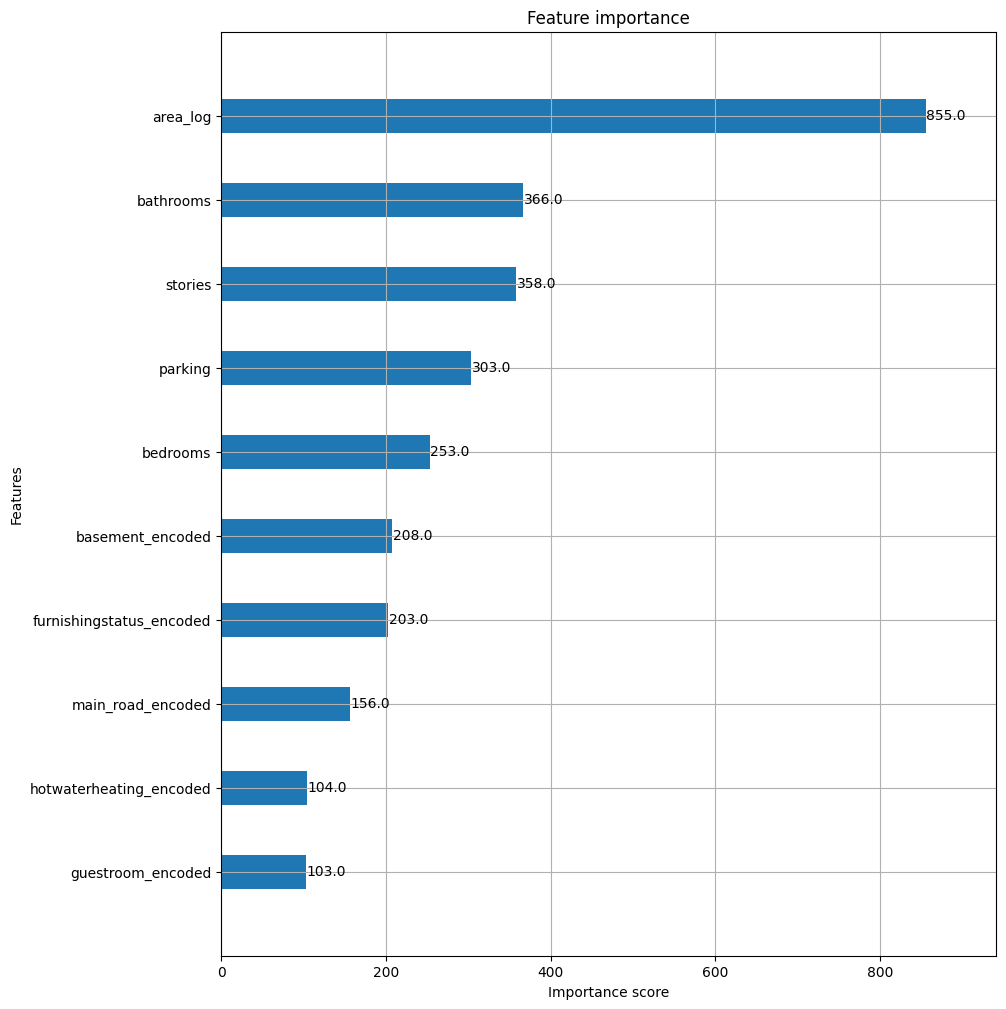

In [ ]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(best_model, ax=ax, max_num_features=30, height=0.4) # 상위 20개만 표시
plt.show()

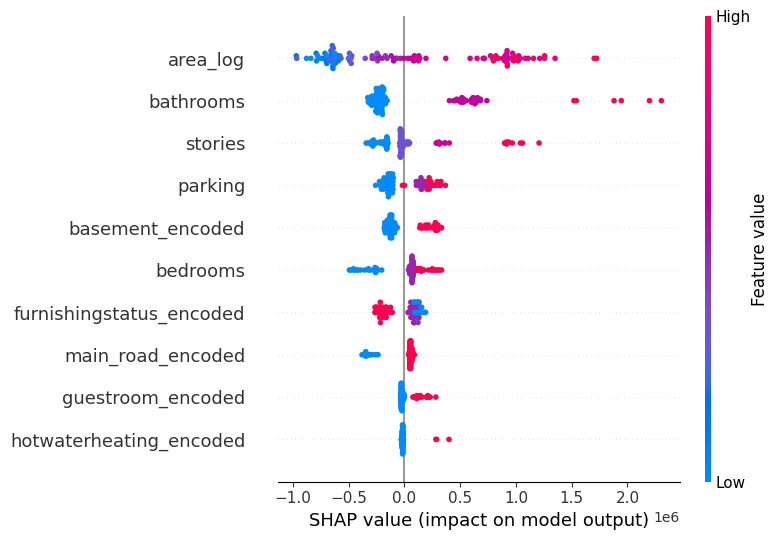

In [ ]:
import shap

# 1. Explainer 생성
explainer = shap.TreeExplainer(best_model)

# 2. SHAP 값 계산 (시간이 좀 걸릴 수 있음)
shap_values = explainer.shap_values(X_test)

# 3. 요약 차트 그리기
shap.summary_plot(shap_values, X_test)

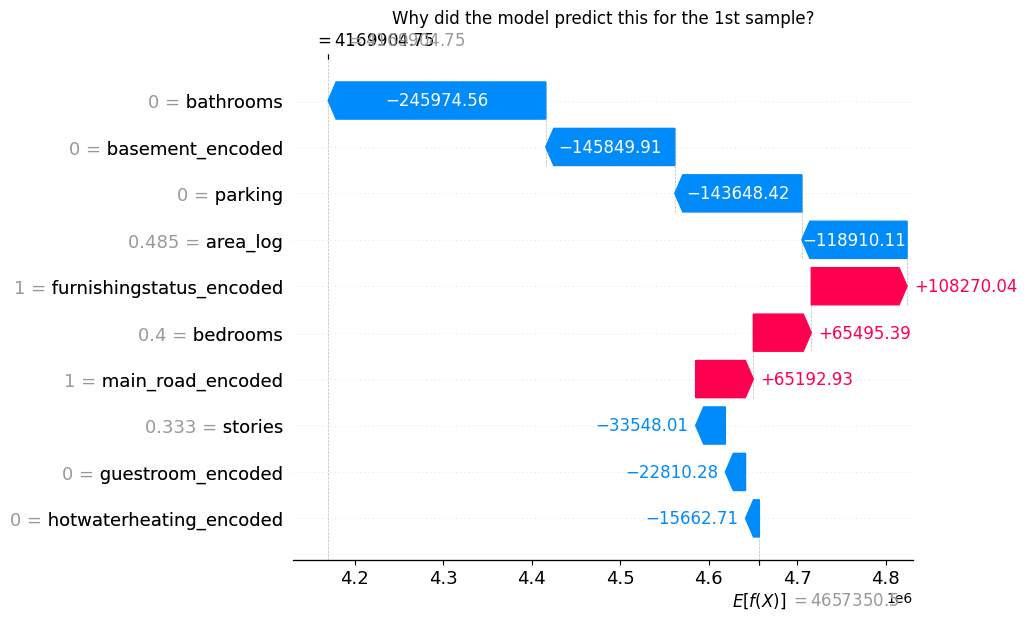

In [ ]:
explainer_obj = shap.Explainer(best_model)
shap_values_obj = explainer_obj(X_test)

# 첫 번째 데이터에 대한 설명 시각화
plt.title("Why did the model predict this for the 1st sample?")
shap.plots.waterfall(shap_values_obj[3])

In [ ]:
shap.initjs()
shap.force_plot(shap_values_obj[3])

In [ ]:
X.head()

,bedrooms,bathrooms,stories,parking,area_log,furnishingstatus_encoded,main_road_encoded,guestroom_encoded,basement_encoded,hotwaterheating_encoded
0,0.6,0.333333,0.666667,0.666667,0.658115,0,1,0,0,0
1,0.6,1.000000,1.000000,1.000000,0.740687,0,1,0,0,0
2,0.4,0.333333,0.333333,0.666667,0.787014,1,1,0,1,0
3,0.6,0.333333,0.333333,1.000000,0.662811,0,1,0,1,0
4,0.6,0.000000,0.333333,0.666667,0.658115,0,1,1,1,0


### 6. 최종 모델 학습 및 저장

In [ ]:
final_params = grid_search.best_params_

print("최종 적용될 파라미터:")
print(final_params)

final_model = XGBRegressor(
    **final_params,
    random_state=42,
    n_jobs=-1
)

print("전체 데이터로 재학습 중...")
final_model.fit(X, y)

print("최종 모델 학습 완료!")

model_filename = 'final_xgboost_model.pkl'
joblib.dump(final_model, model_filename)

print(f"모델이 '{model_filename}' 파일로 저장되었습니다.")


# loaded_model = joblib.load('final_xgboost_model.pkl')
# new_pred = loaded_model.predict(new_data)

최종 적용될 파라미터:
{'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'subsample': 0.7}
전체 데이터로 재학습 중...
최종 모델 학습 완료!
모델이 'final_xgboost_model.pkl' 파일로 저장되었습니다.


GridSearchCV 수행 중...
Fitting 3 folds for each of 54 candidates, totalling 162 fits
--------------------------------------------------
최적의 파라미터: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'subsample': 0.7}
--------------------------------------------------


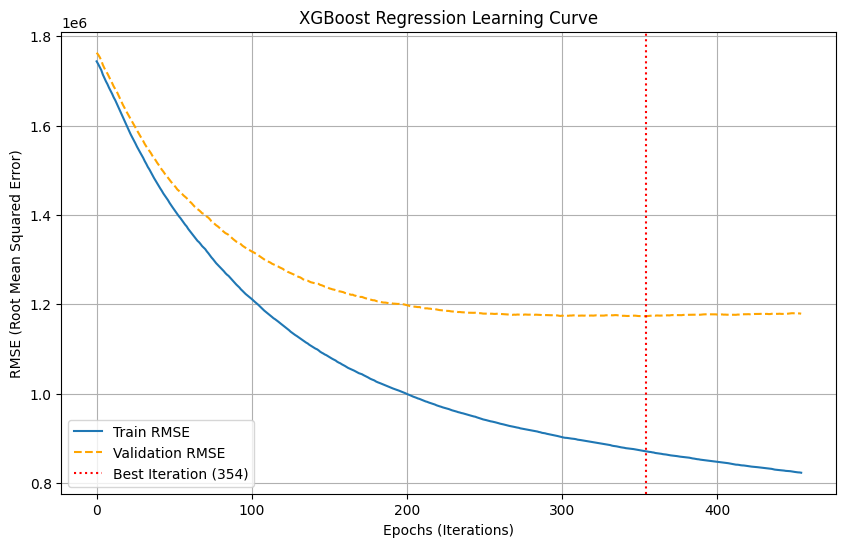

최종 Test RMSE: 1471943.1001
최종 Test MAE : 1046839.6875
최종 Test R2  : 0.5714
최적의 트리 개수(Best Iteration): 354


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # ★ 시각화 라이브러리
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# (가정) X, y 데이터가 정의되어 있다고 가정

# 1. 1차 분할: Train+Val / Test (8:2)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# 2. 2차 분할: Train / Validation (8:2)
# 이 Validation 셋은 Early Stopping 및 학습 곡선 그리기용입니다.
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42, shuffle=True
)

param_grid = {
    'max_depth': [1, 2, 3],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8]
}

# XGBRegressor 설정
xgb_model = XGBRegressor(
    n_estimators=1000,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=100,
    eval_metric='rmse' # ★ 시각화할 때 키 값을 'rmse'로 고정하기 위해 명시
)

kf = KFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=kf,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    refit=True # 최적 파라미터로 다시 학습 (이때 eval_set 기록이 남음)
)

# 3. 학습 수행
print("GridSearchCV 수행 중...")
grid_search.fit(
    X_train, y_train,
    # ★ 중요: 시각화를 위해 Train셋도 eval_set에 포함시켜야 합니다.
    # validation_0: Train, validation_1: Validation
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=False
)

print("-" * 50)
print(f"최적의 파라미터: {grid_search.best_params_}")
print("-" * 50)

best_model = grid_search.best_estimator_

# =========================================================
# ★ [추가된 부분] 학습 곡선 (Learning Curve) 시각화 ★
# =========================================================

# 학습 이력 가져오기
results = best_model.evals_result()

# eval_set 순서에 따라 키가 생성됩니다.
# validation_0 : (X_train, y_train) -> Train RMSE
# validation_1 : (X_val, y_val)     -> Val RMSE
train_rmse = results['validation_0']['rmse']
val_rmse = results['validation_1']['rmse']
epochs = len(train_rmse)
x_axis = range(0, epochs)

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(x_axis, train_rmse, label='Train RMSE')
plt.plot(x_axis, val_rmse, label='Validation RMSE', linestyle='--', color='orange')
plt.legend()
plt.ylabel('RMSE (Root Mean Squared Error)')
plt.xlabel('Epochs (Iterations)')
plt.title('XGBoost Regression Learning Curve')
plt.grid(True)

# 최적의 반복 지점 표시 (Early Stopping에 의해 선택된 지점)
if hasattr(best_model, 'best_iteration'):
    best_iter = best_model.best_iteration
    plt.axvline(best_iter, color='red', linestyle=':', label=f'Best Iteration ({best_iter})')
    plt.legend()

plt.show()

# =========================================================
# 4. 최종 평가
# =========================================================

y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"최종 Test RMSE: {rmse:.4f}")
print(f"최종 Test MAE : {mae:.4f}")
print(f"최종 Test R2  : {r2:.4f}")
print(f"최적의 트리 개수(Best Iteration): {best_model.best_iteration}")